# Initial setup

This section includes installing required libraries and loading environment variables, also making sure GPUs are visible.

### Libraries

In [1]:
# special installation
# !pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git" --quiet

In [2]:
import importlib.util

def install_if_not_exists(package_name, no_deps=False):
    spec = importlib.util.find_spec(package_name)
    if spec is None:
        print(f"[+] Installing {package_name}...")
        if no_deps is False:
          !pip install {package_name} --quiet
        else:
          !pip install --no-deps {package_name} --quiet
    else:
        print(f"[-] {package_name} is already installed.")

In [3]:
# training
install_if_not_exists("xformers", no_deps=True)
install_if_not_exists("trl", no_deps=True)
install_if_not_exists("peft", no_deps=True)
install_if_not_exists("accelerate", no_deps=True)
install_if_not_exists("bitsandbytes", no_deps=True)
install_if_not_exists("torch", no_deps=False)
install_if_not_exists("transformers", no_deps=False)

# datasets
install_if_not_exists("datasets", no_deps=False)
install_if_not_exists("scikit-learn", no_deps=False)
install_if_not_exists("pandas", no_deps=False)
install_if_not_exists("pymongo", no_deps=False)

# other
install_if_not_exists("matplotlib", no_deps=False)
install_if_not_exists("python-dotenv", no_deps=False)
install_if_not_exists("sentry-sdk")
install_if_not_exists("setproctitle", no_deps=False)
install_if_not_exists("wandb", no_deps=False)
install_if_not_exists("click", no_deps=False)
install_if_not_exists("docker-pycreds", no_deps=False)

[-] xformers is already installed.
[-] trl is already installed.
[-] peft is already installed.
[-] accelerate is already installed.
[-] bitsandbytes is already installed.
[-] torch is already installed.
[-] transformers is already installed.
[-] datasets is already installed.
[+] Installing scikit-learn...
[-] pandas is already installed.
[-] pymongo is already installed.
[-] matplotlib is already installed.
[+] Installing python-dotenv...
[+] Installing sentry-sdk...
[-] setproctitle is already installed.
[-] wandb is already installed.
[-] click is already installed.
[+] Installing docker-pycreds...


In [4]:
# core
import os, logging, time, torch, gc, re
from dotenv import load_dotenv
from tqdm.notebook import tqdm
# from unsloth import FastLanguageModel

# dataset
from datasets import Dataset
from pymongo import MongoClient
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
from transformers import(
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    EarlyStoppingCallback,
    AdamW
)

from peft import LoraConfig
from trl import SFTTrainer
from transformers import TrainingArguments
from accelerate import PartialState
from torch.optim.lr_scheduler import ReduceLROnPlateau

# evaluation
import matplotlib.pyplot as plt
from typing import List, Dict, Any
from sklearn.metrics import accuracy_score
import seaborn as sns

In [5]:
if torch.cuda.is_available():
    print("CUDA is available. GPUs detected:")

    # available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Number of available GPUs: {num_gpus}")

    # GPU info
    for i in range(num_gpus):
        print(f"\nGPU {i}:")
        print(f"  Name: {torch.cuda.get_device_name(i)}")
        print(f"  Total Memory: {torch.cuda.get_device_properties(i).total_memory / 1e9:.2f} GB")
        print(f"  Compute Capability: {torch.cuda.get_device_capability(i)}")
        print(f"  Current Memory Allocated: {torch.cuda.memory_allocated(i) / 1e6:.2f} MB")
        print(f"  Current Memory Cached: {torch.cuda.memory_reserved(i) / 1e6:.2f} MB")
else:
    print("CUDA is not available. No GPUs detected.")

CUDA is available. GPUs detected:
Number of available GPUs: 3

GPU 0:
  Name: NVIDIA GeForce RTX 3090
  Total Memory: 25.44 GB
  Compute Capability: (8, 6)
  Current Memory Allocated: 0.00 MB
  Current Memory Cached: 0.00 MB

GPU 1:
  Name: NVIDIA GeForce RTX 3090
  Total Memory: 25.44 GB
  Compute Capability: (8, 6)
  Current Memory Allocated: 0.00 MB
  Current Memory Cached: 0.00 MB

GPU 2:
  Name: NVIDIA GeForce RTX 3090
  Total Memory: 25.44 GB
  Compute Capability: (8, 6)
  Current Memory Allocated: 0.00 MB
  Current Memory Cached: 0.00 MB


### Environment variables and constants

In [6]:
load_dotenv(".env")
CONNECTION_STRING = os.getenv("CONNECTION_STRING")
TOKEN = os.getenv("HUGGINGFACE_TOKEN")
os.environ["TOKENIZERS_PARALLELISM"] = "true"

os.environ["CUDA_VISIBLE_DEVICES"] = "1, 2"

In [7]:
if torch.cuda.is_available():
    print("CUDA is available. GPUs detected:")

    # available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Number of available GPUs: {num_gpus}")

    # GPU info
    for i in range(num_gpus):
        print(f"\nGPU {i}:")
        print(f"  Name: {torch.cuda.get_device_name(i)}")
        print(f"  Total Memory: {torch.cuda.get_device_properties(i).total_memory / 1e9:.2f} GB")
        print(f"  Compute Capability: {torch.cuda.get_device_capability(i)}")
        print(f"  Current Memory Allocated: {torch.cuda.memory_allocated(i) / 1e6:.2f} MB")
        print(f"  Current Memory Cached: {torch.cuda.memory_reserved(i) / 1e6:.2f} MB")
else:
    print("CUDA is not available. No GPUs detected.")

CUDA is available. GPUs detected:
Number of available GPUs: 3

GPU 0:
  Name: NVIDIA GeForce RTX 3090
  Total Memory: 25.44 GB
  Compute Capability: (8, 6)
  Current Memory Allocated: 0.00 MB
  Current Memory Cached: 0.00 MB

GPU 1:
  Name: NVIDIA GeForce RTX 3090
  Total Memory: 25.44 GB
  Compute Capability: (8, 6)
  Current Memory Allocated: 0.00 MB
  Current Memory Cached: 0.00 MB

GPU 2:
  Name: NVIDIA GeForce RTX 3090
  Total Memory: 25.44 GB
  Compute Capability: (8, 6)
  Current Memory Allocated: 0.00 MB
  Current Memory Cached: 0.00 MB


In [8]:
DATABASE_NAME = "APTs"

GPU check (Docker container will sometimes lose GPU visibility)

In [9]:
!nvidia-smi

Sat Jun 15 07:46:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:18:00.0 Off |                  N/A |
| 30%   32C    P8              38W / 350W |   3835MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Dataset loading


Initially, we will be building a dataset with raw text and tools. The dataset is stored in a MongoDB database, so we will have to fetch the data:

In [10]:
collection_name = "blackberry"

In [11]:
client = MongoClient(CONNECTION_STRING)
db = client[DATABASE_NAME]

collection = db[collection_name]

In [12]:
documents = collection.find()

data = []
for doc in documents:

    clause = doc.get("clause", "")
    tactic = doc.get("tactic", "")

    data.append({
        "clause": clause,
        "tactic": tactic
    })

df = pd.DataFrame(data)

print(f"[+] Shape: {df.shape}")
df.head()

[+] Shape: (5000, 2)


,clause,tactic
0,!th 00000050: 69732070726f6772 616d2063616e6e6...,Execution
1,1 / 1 5www .prevailion.com /what-wicked-webs-w...,Initial Access
2,part ii: findings iia: naver -themed phishing ...,Initial Access
3,due ease operator create new subdomains hostin...,Initial Access
4,"accomplish this, lightshow drops legitimate ve...",Other


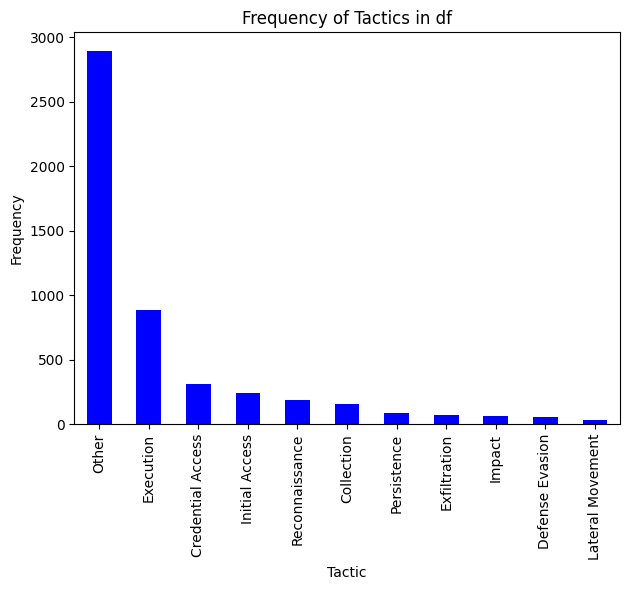

In [13]:
total_tactic_counts = df['tactic'].value_counts()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
total_tactic_counts.plot(kind='bar', color='blue')
plt.title('Frequency of Tactics in df')
plt.xlabel('Tactic')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

There is some clear bias towards `Execution` and `Other`. Even if these tags are the most common in a real-world scenario, it is convenient to downsample them due to the bias observed in experiment #7. The downsampling will be performed bearing in mind that the distribution of our data holds great importance, so they will still be more frequent in the dataset.

For this purpose, a maximum number of samples of 500 will be set.

In [14]:
from sklearn.utils import resample

tactic_counts = df['tactic'].value_counts()
print("[+] Original tactic counts:\n", tactic_counts)

max_samples = 500

# selecting rows to be downsampled
df_other = df[df['tactic'] == 'Other']
df_execution = df[df['tactic'] == 'Execution']

# downsampling
df_other_downsampled = resample(df_other, replace=False, n_samples=max_samples, random_state=42)
df_execution_downsampled = resample(df_execution, replace=False, n_samples=max_samples, random_state=42)

# rebuilding the dataframe
df_remaining = df[~df['tactic'].isin(['Other', 'Execution'])]
balanced_df = pd.concat([df_remaining, df_other_downsampled, df_execution_downsampled])


balanced_tactic_counts = balanced_df['tactic'].value_counts()
print("[+] Balanced tactic counts:\n", balanced_tactic_counts)

[+] Original tactic counts:
 tactic
Other                2895
Execution             884
Credential Access     310
Initial Access        244
Reconnaissance        188
Collection            155
Persistence            90
Exfiltration           75
Impact                 64
Defense Evasion        59
Lateral Movement       36
Name: count, dtype: int64
[+] Balanced tactic counts:
 tactic
Other                500
Execution            500
Credential Access    310
Initial Access       244
Reconnaissance       188
Collection           155
Persistence           90
Exfiltration          75
Impact                64
Defense Evasion       59
Lateral Movement      36
Name: count, dtype: int64


This should reduce the model's bias.

In [15]:
train_df, test_df = train_test_split(balanced_df, test_size=0.1)
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [16]:
print(train_df.shape)
print(test_df.shape)

(1998, 2)
(223, 2)


In [17]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
type(train_dataset)

datasets.arrow_dataset.Dataset

In [18]:
print(f"[+] Training shape: {train_dataset.shape}")
print(f"[+] Test shape: {test_dataset.shape}")

[+] Training shape: (1998, 3)
[+] Test shape: (223, 3)


# Preparing model

In [19]:
from huggingface_hub import login
login(token=TOKEN)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /home/dani/.cache/huggingface/token
Login successful


In [20]:
model_name = "meta-llama/Meta-Llama-3-8B"

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, token=TOKEN)
tokenizer.pad_token = tokenizer.eos_token

# bitsandbytes config for 4bits quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

"""
# bitsandbytes config for 8bits quantization
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_quant_type="dynamic",
    bnb_8bit_compute_dtype=torch.float16,
)
"""

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    trust_remote_code=True,
    use_cache = False,
    device_map="auto",
    #torch_dtype=torch.float16
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Adding LoRA adapters only 1 to 10% of all parameters will need to be updated.

# Preparing data

In [21]:
base_prompt = """Extract tactics from the following text. Tactics represent the "why" of an attack technique or sub-technique. It is a tactical goal or reason for performing an action. Choose one or more from these options
    Reconnaissance, Resource Development, Initial Access, Persistence, Execution, Privilege Escalation, Defense Evasion, Credential Access, Discovery, Lateral Movement, Collection, Command and Control, Exfiltration, Impact
    Extract tactics from the following text.
### Text:
{}

### Response:
{}"""


`EOS_TOKEN` must be added to the tokenized output, otherwise it will return infinite generators.

If you want to use the `llama-3` template for ShareGPT datasets, try our conversational [notebook](https://colab.research.google.com/drive/1XamvWYinY6FOSX9GLvnqSjjsNflxdhNc?usp=sharing).

For text completions like novel writing, try this [notebook](https://colab.research.google.com/drive/1ef-tab5bhkvWmBOObepl1WgJvfvSzn5Q?usp=sharing).

In [22]:
INSTRUCTION = "Please extract the tactics from the given text."

In [23]:
EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN

def formatting_prompts_func(examples):
    inputs       = examples["clause"]
    outputs      = examples["tactic"]
    texts = []
    for input, output in zip(inputs, outputs):
        text = base_prompt.format(input, output) + EOS_TOKEN      # Instruction, Input, Output
        texts.append(text)
    return { "text" : texts, }
pass

In [24]:
train_dataset = train_dataset.map(formatting_prompts_func, batched = True,)
test_dataset = test_dataset.map(formatting_prompts_func, batched = True,)

Map:   0%|          | 0/1998 [00:00<?, ? examples/s]

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

In [25]:
train_dataset

Dataset({
    features: ['clause', 'tactic', '__index_level_0__', 'text'],
    num_rows: 1998
})

Define training parameters

In [26]:
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=100, early_stopping_threshold=0.0001)   # tracks changes to the 4th decimal

In [27]:
torch.cuda.empty_cache()
torch.cuda.empty_cache()      # clearing GPU cache to save some memory
gc.collect()                  # garbage collector

63

# Experiment #9

Default parameters (1st experiment)

In [28]:
# PEFT config
lora_alpha = 16
lora_dropout = 0.1
lora_r = 64

peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["k_proj", "q_proj", "v_proj", "up_proj", "down_proj", "gate_proj"]
)

In [29]:
# Args
max_seq_length = 512  # previously 2048
output_dir = "./results"
per_device_train_batch_size = 8
gradient_accumulation_steps = 2
optim = "adamw_hf"
# save_steps = 10
logging_steps = 50
eval_steps=int(50),
save_steps=int(50),
learning_rate = 1e-5
max_grad_norm = 0.3
max_steps = 3000 # Approx the size of guanaco at bs 8, ga 2, 2 GPUs.
warmup_ratio = 0.1
lr_scheduler_type = "cosine"

In [30]:
training_arguments = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    eval_steps=50,      # won't work unless hardcoded here :/
    save_steps=50,      # idem
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    fp16=True,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=True,
    lr_scheduler_type=lr_scheduler_type,
    gradient_checkpointing=True,
    evaluation_strategy="steps",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    # report_to="wandb",
)

/home/dani/env/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [31]:
import wandb

In [32]:
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=10,
    early_stopping_threshold=0.001
)

In [33]:
# Trainer
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    dataset_text_field="text",
    peft_config=peft_config,
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    callbacks=[early_stopping]
)

/home/dani/env/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/home/dani/env/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/dani/env/lib/python3.10/site-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/home/dani/env/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.4

Map:   0%|          | 0/1998 [00:00<?, ? examples/s]

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


# Training

Schedulers and callbacks

In [35]:
weight_decay = 0.3  
factor = 0.5 
patience = 5  

In [36]:
optimizer = AdamW(
    trainer.model.parameters(),
    lr=trainer.args.learning_rate,
    weight_decay=trainer.args.weight_decay
)


scheduler = ReduceLROnPlateau(
    optimizer=optimizer,
    mode='min',
    factor=factor,
    patience=patience,
    threshold=0.001,
    threshold_mode='rel',
    cooldown=0,
    min_lr=0,
    eps=1e-8,
    verbose=True
)

trainer.optimizer = optimizer
trainer.lr_scheduler = scheduler

/home/dani/env/lib/python3.10/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [37]:
print("[+] Using optimizer:", trainer.optimizer)
print("[+] Using scheduler:", trainer.lr_scheduler)

[+] Using optimizer: AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    lr: 1e-05
    weight_decay: 0.0
)
[+] Using scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7f2b7362d810>


Allocated memory before clearing:

In [38]:
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_reserved())

2386632704
3435134976


In [39]:
torch.cuda.empty_cache()
torch.cuda.empty_cache()      # clearing GPU cache to save some memory
gc.collect()                  # garbage collector

347

Allocated memory after clearing:

In [40]:
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_reserved())

2386632704
3435134976


Training

In [41]:
trainer_stats = trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: w-dan (seclab-etsisi). Use `wandb login --relogin` to force relogin


/home/dani/env/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
50,3.108800,2.939895
100,2.632400,2.412871
150,2.240000,2.259425
200,2.201700,2.219532
250,2.061900,2.190013
300,2.109600,2.161615
350,2.049700,2.132534
400,2.020100,2.109203
450,2.021900,2.091116
500,1.935600,2.074628


/home/dani/env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/dani/env/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/dani/env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `

In [43]:
torch.cuda.empty_cache()
torch.cuda.empty_cache()      # clearing GPU cache to save some memory
gc.collect()                  # garbage collector

53

In [44]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 1.9591691493988037, 'eval_runtime': 42.6474, 'eval_samples_per_second': 5.229, 'eval_steps_per_second': 0.657, 'epoch': 15.6}


In [45]:
"""#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")"""

'#@title Show final memory and time stats\nused_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)\nused_memory_for_lora = round(used_memory - start_gpu_memory, 3)\nused_percentage = round(used_memory         /max_memory*100, 3)\nlora_percentage = round(used_memory_for_lora/max_memory*100, 3)\nprint(f"{trainer_stats.metrics[\'train_runtime\']} seconds used for training.")\nprint(f"{round(trainer_stats.metrics[\'train_runtime\']/60, 2)} minutes used for training.")\nprint(f"Peak reserved memory = {used_memory} GB.")\nprint(f"Peak reserved memory for training = {used_memory_for_lora} GB.")\nprint(f"Peak reserved memory % of max memory = {used_percentage} %.")\nprint(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")'

# Evaluation

In [46]:
def plot_training_logs(logs: List[Dict[str, float]]) -> None:
    """
    Plot training loss, validation loss, and learning rate over time.

    Args:
    logs (List[Dict[str, float]]): List of log entries containing metrics like loss, validation loss, and learning rate.
    """
    steps_loss = [log['step'] for log in logs if 'loss' in log]
    loss = [log['loss'] for log in logs if 'loss' in log]
    learning_rate = [log['learning_rate'] for log in logs if 'learning_rate' in log]
    steps_eval = [log['step'] for log in logs if 'eval_loss' in log]
    eval_loss = [log['eval_loss'] for log in logs if 'eval_loss' in log]

    plt.figure(figsize=(14, 5))
    plt.plot(steps_loss, loss, label='Training Loss')
    plt.plot(steps_eval, eval_loss, label='Validation Loss', color='red')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('training_and_validation_loss.png')
    plt.show()

    plt.figure(figsize=(14, 5))
    plt.plot(steps_loss, learning_rate[:len(steps_loss)], label='Learning Rate', color='orange')
    plt.xlabel('Steps')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.legend()
    plt.grid(True)
    plt.savefig('learning_rate_schedule.png')
    plt.show()

In [47]:
trainer.state.log_history

[{'loss': 3.1088,
  'grad_norm': 0.40133559703826904,
  'learning_rate': 1e-05,
  'epoch': 0.4,
  'step': 50},
 {'eval_loss': 2.939894914627075,
  'eval_runtime': 42.3634,
  'eval_samples_per_second': 5.264,
  'eval_steps_per_second': 0.661,
  'epoch': 0.4,
  'step': 50},
 {'loss': 2.6324,
  'grad_norm': 0.2836415767669678,
  'learning_rate': 1e-05,
  'epoch': 0.8,
  'step': 100},
 {'eval_loss': 2.4128708839416504,
  'eval_runtime': 42.4344,
  'eval_samples_per_second': 5.255,
  'eval_steps_per_second': 0.66,
  'epoch': 0.8,
  'step': 100},
 {'loss': 2.24,
  'grad_norm': 0.27025121450424194,
  'learning_rate': 1e-05,
  'epoch': 1.2,
  'step': 150},
 {'eval_loss': 2.259425163269043,
  'eval_runtime': 42.3703,
  'eval_samples_per_second': 5.263,
  'eval_steps_per_second': 0.661,
  'epoch': 1.2,
  'step': 150},
 {'loss': 2.2017,
  'grad_norm': 0.28375187516212463,
  'learning_rate': 1e-05,
  'epoch': 1.6,
  'step': 200},
 {'eval_loss': 2.219531774520874,
  'eval_runtime': 42.3232,
  'eval

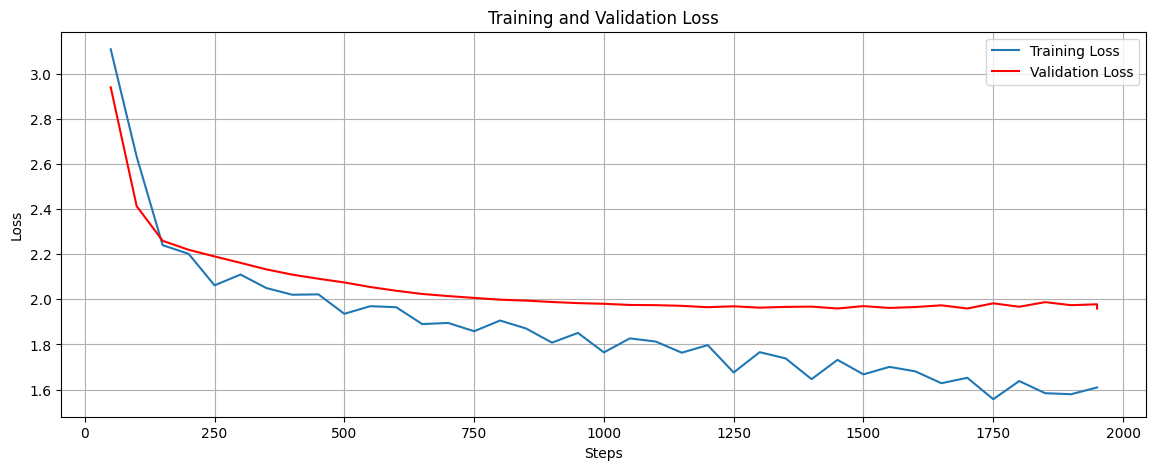

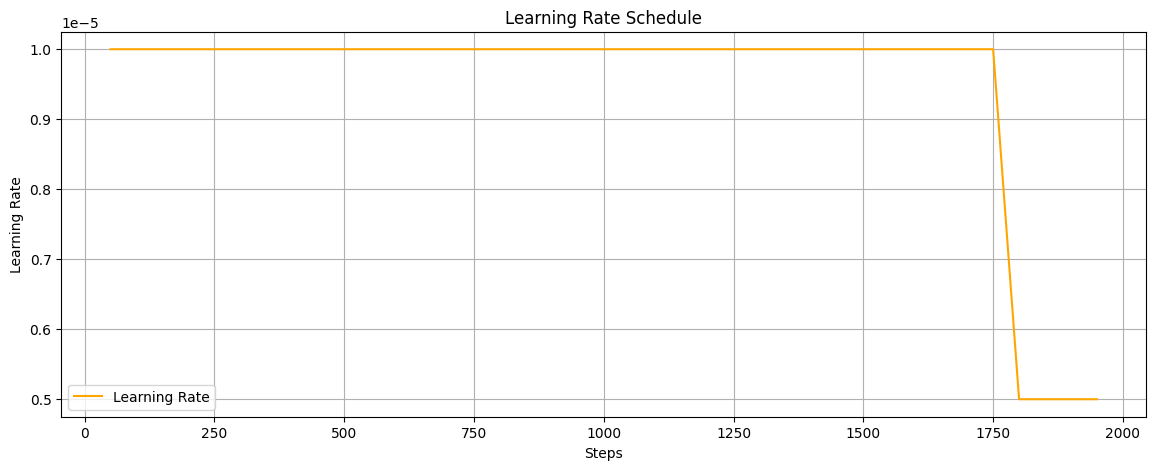

In [48]:
plot_training_logs(trainer.state.log_history)

# Test dataframe inferences (accuracy measure)

In [49]:
def extract_response_text(text: str) -> str:
    """
    Extract the text after '### Response:' from the given string.

    Args:
    text (str): The input string containing the '### Response:' section.

    Returns:
    str: The extracted response text.
    """
    marker = "### Response:"
    start_index = text.find(marker)

    if start_index == -1:
        return ""  # Marker not found, return an empty string

    start_index += len(marker)
    response_text = text[start_index:].strip()

    return response_text

In [50]:


def predict_tactic(input_text):
    inputs = tokenizer(
    [
        base_prompt.format(
            input_text, # input
            "", # output
        )
    ], return_tensors = "pt").to("cuda")

    outputs = model.generate(**inputs, max_new_tokens=64, use_cache=True)
    text_output = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return text_output[0]

# genrating predictions to calculate accuracy on test dataset
true_labels = test_df["tactic"].tolist()
predicted_labels = []

#answer = predict_tactic(test_clause)
#print(f"[+] Answer: {extract_response_text(answer)}")



for _, row in tqdm(test_df.iterrows(), total=test_df.shape[0], desc="Processing dataset"):
    input_text = row["clause"]
    model_response = predict_tactic(input_text)
    predicted_tactic = extract_response_text(model_response)

    predicted_labels.append(predicted_tactic)

Processing dataset:   0%|          | 0/223 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

Little boilerplate to compute predictions

In [51]:
mitre_tactics = [
    "Initial Access", "Execution", "Persistence", "Privilege Escalation",
    "Defense Evasion", "Credential Access", "Discovery", "Lateral Movement",
    "Collection", "Exfiltration", "Command and Control", "Impact", "Other"
]

tactics_pattern = re.compile(r'|'.join([re.escape(tactic) for tactic in mitre_tactics]), re.IGNORECASE)
def extract_first_tactic(text):
    match = tactics_pattern.search(text)
    if match:
        return match.group(0)
    return None

In [52]:
# and finally calculate accuracy
test_df_with_preds = test_df.copy()
test_df_with_preds['predicted_labels'] = predicted_labels
test_df_with_preds["predicted_labels"] = test_df_with_preds["predicted_labels"].apply(extract_first_tactic)

correct_predictions = sum(test_df_with_preds["tactic"] == test_df_with_preds["predicted_labels"])
accuracy = correct_predictions / len(test_df_with_preds)
print(f"[+] Accuracy: {accuracy * 100:.2f}%")

[+] Accuracy: 59.19%


In [53]:
test_df_with_preds

,clause,tactic,predicted_labels
2435,27 accountability government pla remain unclea...,Persistence,Other
2288,(1) attacker sends spear -phishing email conta...,Initial Access,Initial Access
3414,immediate direct impacts deepwater horizon oil...,Impact,Impact
2406,"however, despite attracted little public atten...",Collection,Collection
3956,"program maintains two sockets, sending heartbe...",Execution,Execution
...,...,...,...
221,14 badnews backdoor .............................,Other,Other
4373,screenshots victims pc showing infection proce...,Initial Access,Initial Access
2264,"february 16, 2018 letter sandvine laid company...",Other,Other
399,public f-secure.com | f -secure labs 3 content...,Exfiltration,Exfiltration


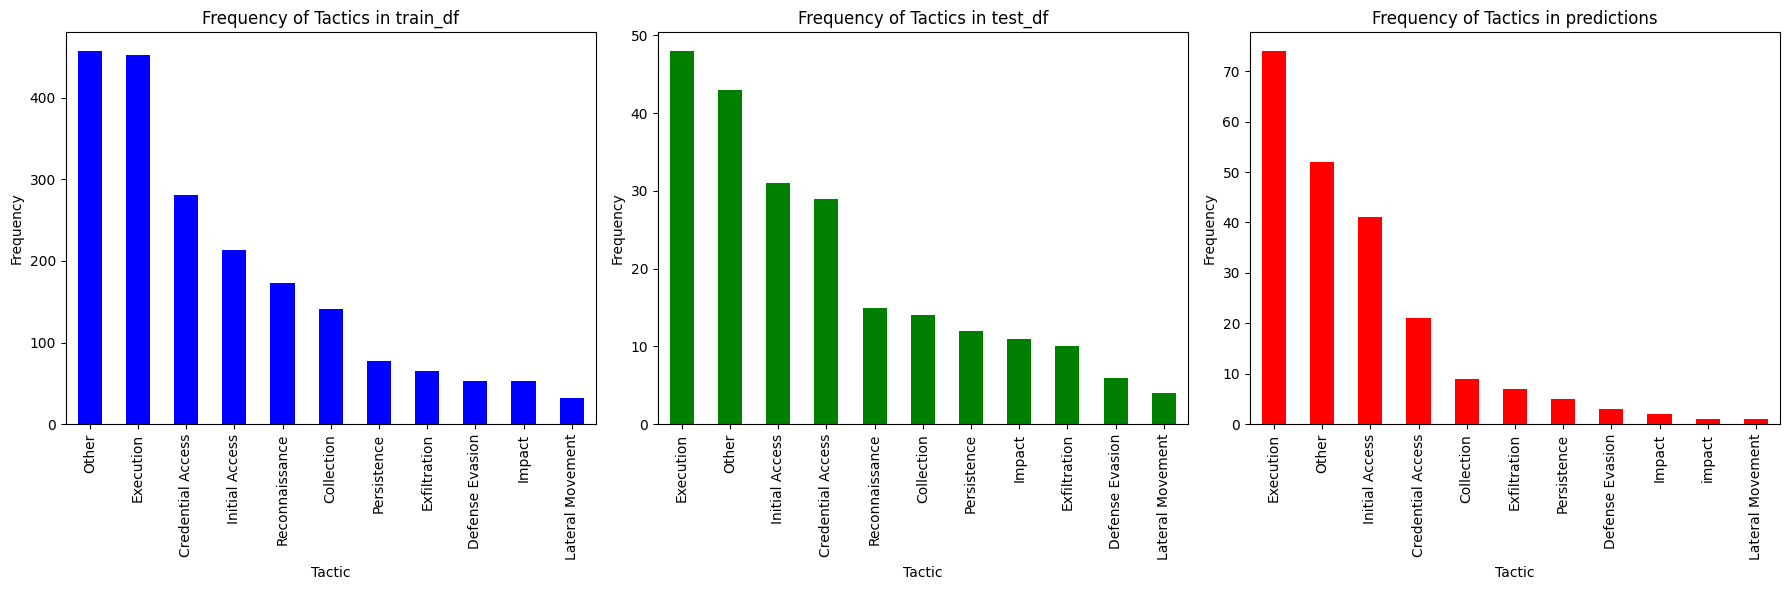

In [54]:
train_tactic_counts = train_df['tactic'].value_counts()
test_tactic_counts = test_df['tactic'].value_counts()
pred_tactic_counts = test_df_with_preds['predicted_labels'].value_counts()

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
train_tactic_counts.plot(kind='bar', color='blue')
plt.title('Frequency of Tactics in train_df')
plt.xlabel('Tactic')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
test_tactic_counts.plot(kind='bar', color='green')
plt.title('Frequency of Tactics in test_df')
plt.xlabel('Tactic')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
pred_tactic_counts.plot(kind='bar', color='red')
plt.title('Frequency of Tactics in predictions')
plt.xlabel('Tactic')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

The model fits to the distribution correctly. Let's analyze the wrong predictions:

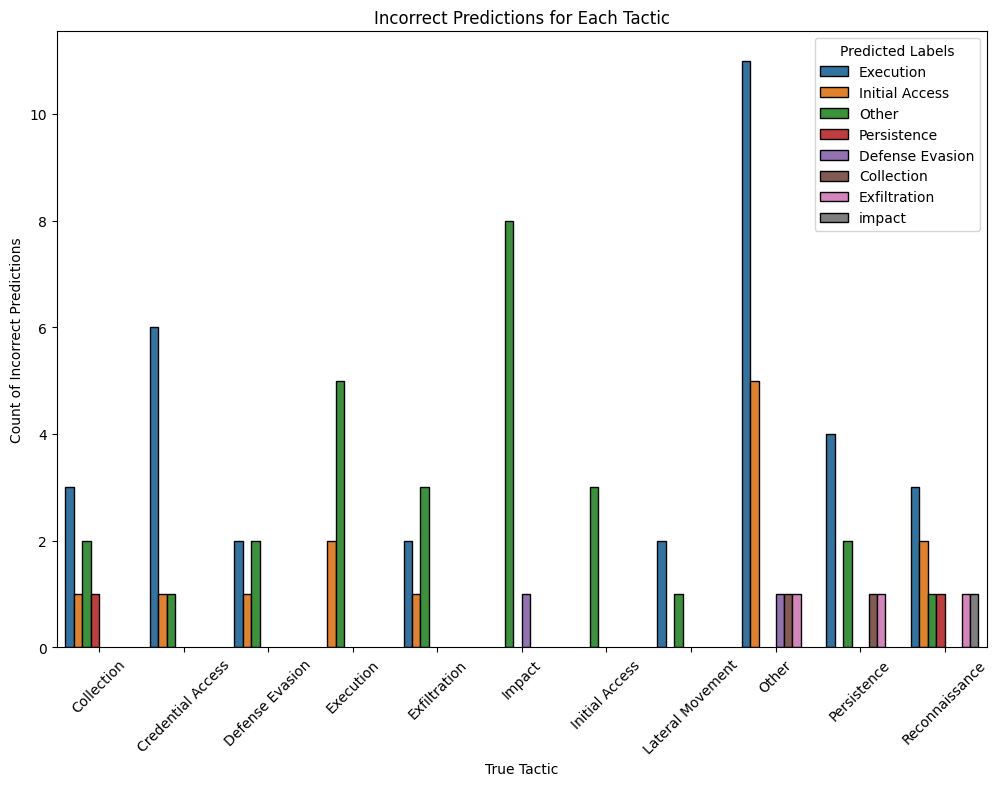

In [55]:
incorrect_predictions = test_df_with_preds[test_df_with_preds["tactic"] != test_df_with_preds["predicted_labels"]]
error_counts = incorrect_predictions.groupby(["tactic", "predicted_labels"]).size().reset_index(name="count")

plt.figure(figsize=(12, 8))
sns.barplot(data=error_counts, x="tactic", y="count", hue="predicted_labels", edgecolor="black")
plt.title("Incorrect Predictions for Each Tactic")
plt.xlabel("True Tactic")
plt.ylabel("Count of Incorrect Predictions")
plt.legend(title="Predicted Labels")
plt.xticks(rotation=45)
plt.show()


It is clear that `Collection` is often mistaken by `Discovery`. The most widely mistaken variable is `Execution`.

In [56]:
"""FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    base_prompt.format(
        # INSTRUCTION, # instruction
        report, # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
text_output = tokenizer.batch_decode(outputs)"""

'FastLanguageModel.for_inference(model) # Enable native 2x faster inference\ninputs = tokenizer(\n[\n    base_prompt.format(\n        #\xa0INSTRUCTION, # instruction\n        report, # input\n        "", # output - leave this blank for generation!\n    )\n], return_tensors = "pt").to("cuda")\n\noutputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)\ntext_output = tokenizer.batch_decode(outputs)'

In [57]:
"""
from unsloth import unsloth_save_model
# Import the unsloth_save_model function from the Unsloth library

# unsloth_save_model has the same args as model.save_pretrained
# unsloth_save_model has the same arguments as model.save_pretrained
unsloth_save_model(model, tokenizer, "output_model", push_to_hub=False, token=None)
# Save the model and tokenizer as "output_model". Do not push to the Hugging Face Hub

colab_quantize_to_gguf("output_model", quantization_method="q4_k_m")
"""

'\nfrom unsloth import unsloth_save_model\n# Import the unsloth_save_model function from the Unsloth library\n\n# unsloth_save_model has the same args as model.save_pretrained\n# unsloth_save_model has the same arguments as model.save_pretrained\nunsloth_save_model(model, tokenizer, "output_model", push_to_hub=False, token=None)\n# Save the model and tokenizer as "output_model". Do not push to the Hugging Face Hub\n\ncolab_quantize_to_gguf("output_model", quantization_method="q4_k_m")\n'